## Inference for ResNet 50 using ONNX Runtime

This example demonstrates how to load an image classification model from the [ONNX model zoo](https://github.com/onnx/models) and confirm its accuracy based on included test data.

In [1]:
import numpy as np    # we're going to use numpy to process input and output data
import onnxruntime    # to inference ONNX models, we use the ONNX Runtime
import onnx
from onnx import numpy_helper
import urllib.request
import json
import time

# display images in notebook
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

%matplotlib inline

In [2]:
onnx_model_url = "https://s3.amazonaws.com/onnx-model-zoo/resnet/resnet50v2/resnet50v2.tar.gz"
imagenet_labels_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"

# retrieve our model from the ONNX model zoo
urllib.request.urlretrieve(onnx_model_url, filename="resnet50v2.tar.gz")
urllib.request.urlretrieve(imagenet_labels_url, filename="imagenet-simple-labels.json")

!tar xvzf resnet50v2.tar.gz --warning=no-unknown-keyword

resnet50v2/
resnet50v2/._resnet50v2.onnx
resnet50v2/resnet50v2.onnx
resnet50v2/test_data_set_0/
resnet50v2/test_data_set_1/
resnet50v2/test_data_set_2/
resnet50v2/test_data_set_2/._input_0.pb
resnet50v2/test_data_set_2/input_0.pb
resnet50v2/test_data_set_2/output_0.pb
resnet50v2/test_data_set_1/._input_0.pb
resnet50v2/test_data_set_1/input_0.pb
resnet50v2/test_data_set_1/output_0.pb
resnet50v2/test_data_set_0/._input_0.pb
resnet50v2/test_data_set_0/input_0.pb
resnet50v2/test_data_set_0/output_0.pb


### Load sample inputs and outputs

In [3]:
test_data_dir = 'resnet50v2/test_data_set'
test_data_num = 3

In [4]:
import glob
import os

# Load inputs
inputs = []
for i in range(test_data_num):
    input_file = os.path.join(test_data_dir + '_{}'.format(i), 'input_0.pb')
    tensor = onnx.TensorProto()
    with open(input_file, 'rb') as f:
        tensor.ParseFromString(f.read())
        inputs.append(numpy_helper.to_array(tensor))

print('Loaded {} inputs successfully.'.format(test_data_num))
        
# Load reference outputs

ref_outputs = []
for i in range(test_data_num):
    output_file = os.path.join(test_data_dir + '_{}'.format(i), 'output_0.pb')
    tensor = onnx.TensorProto()
    with open(output_file, 'rb') as f:
        tensor.ParseFromString(f.read())    
        ref_outputs.append(numpy_helper.to_array(tensor))
        
print('Loaded {} reference outputs successfully.'.format(test_data_num))

Loaded 3 inputs successfully.
Loaded 3 reference outputs successfully.


### Inference using ONNX Runtime

In [5]:
# Run the model on the backend
session = onnxruntime.InferenceSession('resnet50v2/resnet50v2.onnx', None)

# get the name of the first input of the model
input_name = session.get_inputs()[0].name  

print('Input Name:', input_name)

Input Name: data


In [6]:
%%time
outputs = [session.run([], {input_name: inputs[i]})[0] for i in range(test_data_num)]

Wall time: 166 ms


In [7]:
print('Predicted {} results.'.format(len(outputs)))

# Compare the results with reference outputs up to 4 decimal places
for ref_o, o in zip(ref_outputs, outputs):
    np.testing.assert_almost_equal(ref_o, o, 4)
    
print('ONNX Runtime outputs are similar to reference outputs!')

Predicted 3 results.
ONNX Runtime outputs are similar to reference outputs!


### Classify sample images using our inference session

**Input**: A 224 x 224 pixel image that contains an object

**Task**: Identify the content of input images

**Output**: Class prediction for input image

In [8]:
def load_labels(path):
    with open(path) as f:
        data = json.load(f)
    return np.asarray(data)

def preprocess(input_data):
    # convert the input data into the float32 input
    img_data = input_data.astype('float32')
    img_data = img_data.reshape(1, 3, 224, 224)

    #normalize
    mean_vec = np.array([0.485, 0.456, 0.406])
    stddev_vec = np.array([0.229, 0.224, 0.225])
    norm_img_data = np.zeros(img_data.shape).astype('float32')
    for i in range(img_data.shape[0]):
        norm_img_data[i,:,:] = (img_data[i,:,:]/255 - mean_vec[i]) / stddev_vec[i]
    return norm_img_data

def softmax(x):
    x = x.reshape(-1)
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def postprocess(result):
    return softmax(np.array(result)).tolist()

Image size:  (224, 224)


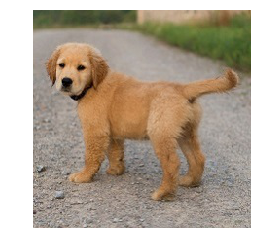

In [9]:
labels = load_labels('imagenet-simple-labels.json')
image = Image.open('images/dog.jpg')
# image = Image.open('images/plane.jpg')

print("Image size: ", image.size)
plt.axis('off')
display_image = plt.imshow(image)
image_data = np.array(image).transpose(2, 0, 1)
input_data = preprocess(image_data)

In [10]:
start = time.time()
raw_result = session.run([], {input_name: input_data})
end = time.time()
res = postprocess(raw_result)

Final top prediction is: Golden Retriever
Inference time: 68.0 ms
============ Top 5 labels are: ============================
['Golden Retriever' 'Labrador Retriever' 'Otterhound' 'Sussex Spaniel'
 'Vizsla']


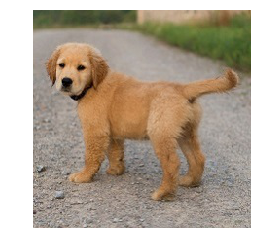

In [11]:
inference_time = np.round((end - start) * 1000, 2)
idx = np.argmax(res)

print('========================================')
print('Final top prediction is: ' + labels[idx])
print('========================================')

print('========================================')
print('Inference time: ' + str(inference_time) + " ms")
print('========================================')

sort_idx = np.flip(np.squeeze(np.argsort(res)))
print('============ Top 5 labels are: ============================')
print(labels[sort_idx[:5]])
print('===========================================================')

plt.axis('off')
display_image = plt.imshow(image)